# Monitoramento do Distanciamento Social
Para monitorar o distanciamento social em vídeos, vamos seguir os seguintes passos:

1.   Obter um frame do video
2.   Detectar pedestres no frame
2.   Obter localização de cada pedestre
3.   Calcular distâncias entre pedestres
4.   Filtrar os pedestres mais próximos um do outro
5.   Mostrar um alerta para aqueles que estão mais próximos
6.   Repetir os passos anteriores para cada frame no video

**Importante!**

Verificar que o tipo de ambiente de execução é **GPU**.
Para mudar o tipo de ambiente de execução, ir para:

`Ambiente de execução -> Alterar tipo de ambiente de execução`

Em Acelerador de hardware, selecionar **GPU**

## Montar o Drive

Executando as seguinte linhas de codigo, podemos montar nosso Google Drive no Colab:

```python
from google.colab import drive
drive.mount('/content/drive')
```
Depois, um link sera apresentado onde temos que accesar para obter um token. Finalmente temos que colar o token nosso Colab para permitir o acceso ao nossos arquivos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/My\ Drive/Colabs/Social_Distance

/content/drive/My Drive/Colabs/Social_Distance


## Instalar Dependencias

Neste caso, vamos precisar da biblioteca [detectron2](https://github.com/facebookresearch/detectron2) para fazer a detecção de pedestres.


```
!pip install cython pyyaml==5.1
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
```
Detectron2 é desenvolvido pela Facebook AI Research (FAIR) e implementa *state-of-the-art* algoritmos para detecção de objetos. 
![Detectron2](https://user-images.githubusercontent.com/1381301/66535560-d3422200-eace-11e9-9123-5535d469db19.png)

In [ ]:
!pip install cython pyyaml==5.1
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=d6221e0d451425bda1d53eb71b4c4d080ad577a0474003c3e56d9d003efaa190
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 63.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200704-cp36-none-any.whl size=41894 sha256=2869f2aa089bb7944b238c9edd7cd1a631678b562365546ee0689a1646e35375
  Stored in directory: /root/.cache/pip/wheels/fb/d2/8e/b6d0f19811e77dabff1ebed6605ce2b59ee9f487079b434c8c
Successfully built fvcore


##Import das bibliotecas necessarias

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd
from tqdm import tqdm_notebook

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## Parâmetros do algoritmo de detecção

In [ ]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f97cb7.pkl: 136MB [00:13, 10.1MB/s]                           


## Processando um frame

### Leitura da Imagem

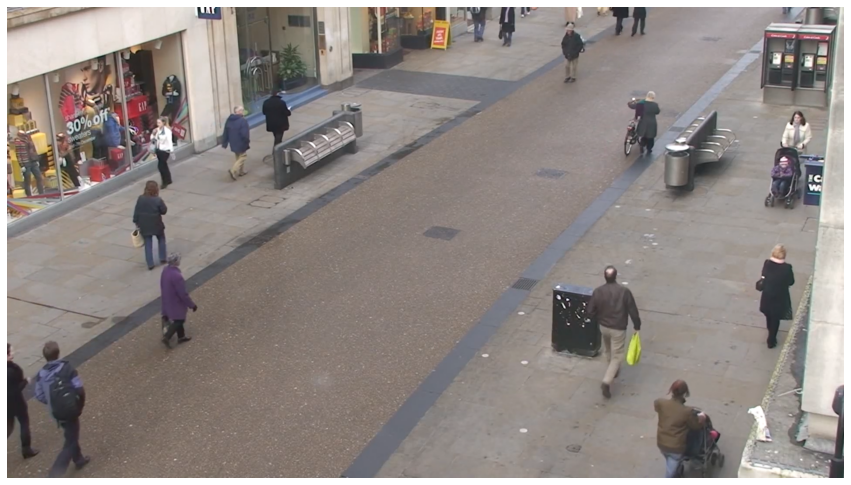

In [ ]:
image_filename = "frame_1.png"
image = cv2.imread(image_filename,1)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,10))
plt.imshow(image)
plt.axis("off")
plt.show()

### Aplicando o algoritmo de detecção

In [ ]:
outputs = predictor(image)
outputs

{'instances': Instances(num_instances=19, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[1.3192e+03, 5.9615e+02, 1.4570e+03, 9.0577e+02],
         [1.7176e+03, 5.3864e+02, 1.8083e+03, 7.8730e+02],
         [3.4504e+02, 5.5842e+02, 4.4022e+02, 7.8227e+02],
         [1.4795e+03, 8.5180e+02, 1.6203e+03, 1.0760e+03],
         [1.2696e+03, 3.9643e+01, 1.3251e+03, 1.7796e+02],
         [5.8722e+02, 1.9110e+02, 6.5464e+02, 3.2032e+02],
         [5.8820e+01, 7.6285e+02, 1.9178e+02, 1.0717e+03],
         [2.9025e+02, 4.0051e+02, 3.8212e+02, 6.0823e+02],
         [4.9258e+02, 2.2458e+02, 5.6332e+02, 3.9755e+02],
         [1.8881e+00, 7.7421e+02, 7.4056e+01, 1.0357e+03],
         [3.2930e+02, 2.4525e+02, 3.8863e+02, 4.1883e+02],
         [1.1233e+03, 4.4730e-01, 1.1685e+03, 9.2831e+01],
         [1.4273e+03, 0.0000e+00, 1.4661e+03, 6.9020e+01],
         [1.3880e+03, 6.0547e-01, 1.4227e+03, 6.4735e+01],
         [1.0650e+01, 2.6954e+02, 9.5215e+01, 4.3718e+02],
         [1

### Visualizando os objetos encontrados

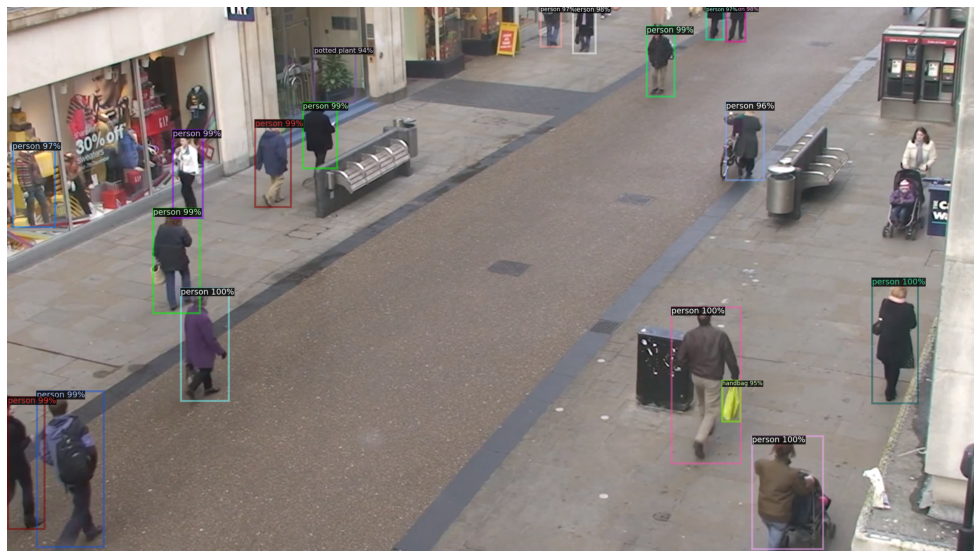

In [ ]:
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(20,10))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

### Tipos de objetos encontrados e sua localização

In [ ]:
classes = outputs['instances'].pred_classes.cpu().numpy()
objects_locations = outputs['instances'].pred_boxes.tensor.cpu().numpy()
print("Classes encontradas: ", classes)
print("Localização de cada objeto: ")
df = pd.DataFrame(data=objects_locations, columns=["x1", "y1", "x2", "y2"])
df

Classes encontradas:  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 26 58]
Localização de cada objeto: 


x1          y1           x2           y2
0   1319.169312  596.149353  1456.959595   905.765991
1   1717.596558  538.640686  1808.336670   787.298035
2    345.035431  558.416443   440.224731   782.268799
3   1479.543823  851.799744  1620.274658  1075.958984
4   1269.597656   39.642517  1325.134033   177.955368
5    587.218811  191.096039   654.635376   320.318634
6     58.820499  762.851746   191.779251  1071.684814
7    290.245422  400.505066   382.118408   608.225708
8    492.578796  224.577393   563.321106   397.549622
9      1.888132  774.211487    74.055748  1035.745850
10   329.295013  245.247986   388.630890   418.830231
11  1123.303223    0.447303  1168.541992    92.831291
12  1427.337402    0.000000  1466.105225    69.019897
13  1388.023682    0.605470  1422.743164    64.734840
14    10.650186  269.540070    95.215019   437.179688
15  1059.175049    0.000000  1100.000488    79.293518
16  1427.903320  190.185165  1502.121338   344.106628
17  1420.253784  742.178345  1455.809570   822.454163
18   609.800598   81.791702   691.369446   189.110947

### Filtrando a classe pedestre e suas localizações

In [ ]:
persons_index = np.where(classes==0)[0]
persons_locations = objects_locations[persons_index]
persons_total = len(persons_locations)
print("Número de pedestres: {}".format(persons_total))

Número de pedestres: 17


### Calculando o ponto médio da localização de cada pedestre

In [ ]:
#@title Obtem o ponto médio do bounding box e desenha um retângulo verde para cada pedestre e um ponto azul no ponto médio
def get_mid_point(image, persons_locations, idx, text=False):
  # draw a green rectangle over the person
  x1,y1,x2,y2 = persons_locations[idx]
  _ = cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
  
  # compute bottom center and draw it
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  _ = cv2.circle(image, mid, 5, (0, 0, 255), -1)
  
  if text:
    cv2.putText(image, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
  return mid

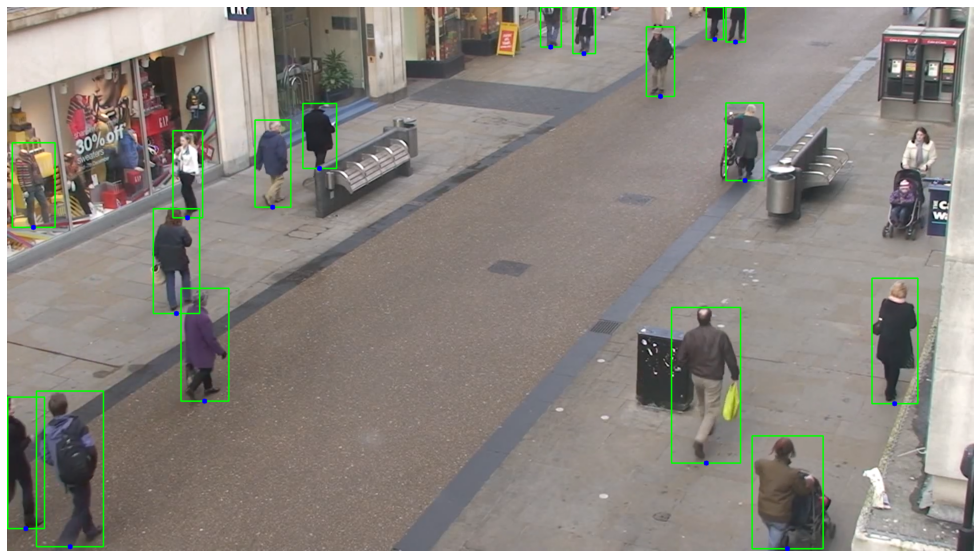

In [ ]:
midpoints = [get_mid_point(image, persons_locations, i) for i in range(persons_total)]

plt.figure(figsize=(20,10))
plt.imshow(image)
plt.axis("off")
plt.show()

### Calculando as distâncias entre cada pedestre

In [ ]:
#@title Calcula a distância euclidiana entre os pontos médios de cada pedestre
def compute_distances(midpoints, num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

In [ ]:
distances = compute_distances(midpoints, persons_total)
df = pd.DataFrame(data=distances)
print("Distâncias entre cada pedestre")
df

Distâncias entre cada pedestre


0           1            2   ...           14           15           16
0   0.0  392.173431  1003.566141  ...  1415.598813   881.905324   566.259658
1   0.0    0.000000  1370.009124  ...  1745.451231   983.744377   533.346042
2   0.0    0.000000     0.000000  ...   484.381048   982.943539  1158.953407
3   0.0    0.000000     0.000000  ...  1627.283933  1101.324657   735.810438
4   0.0    0.000000     0.000000  ...  1271.858876   239.014644   236.881827
5   0.0    0.000000     0.000000  ...   579.924995   518.422608   845.340760
6   0.0    0.000000     0.000000  ...   638.188844  1376.292120  1524.509429
7   0.0    0.000000     0.000000  ...   331.507164   912.080040  1159.455476
8   0.0    0.000000     0.000000  ...   476.681235   637.046309   939.496142
9   0.0    0.000000     0.000000  ...   598.188098  1414.107492  1586.400013
10  0.0    0.000000     0.000000  ...   306.589302   796.719524  1109.470594
11  0.0    0.000000     0.000000  ...  1146.156185    67.268120   407.313147
12  0.0    0.000000     0.000000  ...  1441.755874   367.136215   275.655582
13  0.0    0.000000     0.000000  ...  1403.473548   326.344910   286.356421
14  0.0    0.000000     0.000000  ...     0.000000  1087.608845  1416.057202
15  0.0    0.000000     0.000000  ...     0.000000     0.000000   468.210423
16  0.0    0.000000     0.000000  ...     0.000000     0.000000     0.000000

[17 rows x 17 columns]

### Filtrando os pedestres mais próximos um do outro

In [ ]:
#@title Com base em um determinado limiar, os pedestres mais próximos um do outro são obtidos
def find_closest_points(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if (i is not j) and (dist[i][j]<=thresh):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

In [ ]:
threshold = 100
p1, p2, d = find_closest_points(distances, persons_total, threshold)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df

p1  p2       dist
0   6   9  95.078915
1  11  15  67.268120
2  12  13  41.303753

### Mostrar pedestres mais próximos

In [ ]:
#@title Desenha um retângulo vermelho nos pedestres que ficaram mais próximos um do outro
def change_2_red(image, persons_locations, p1, p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = persons_locations[i]
    # draw red rectangle over the person
    _ = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
  return image

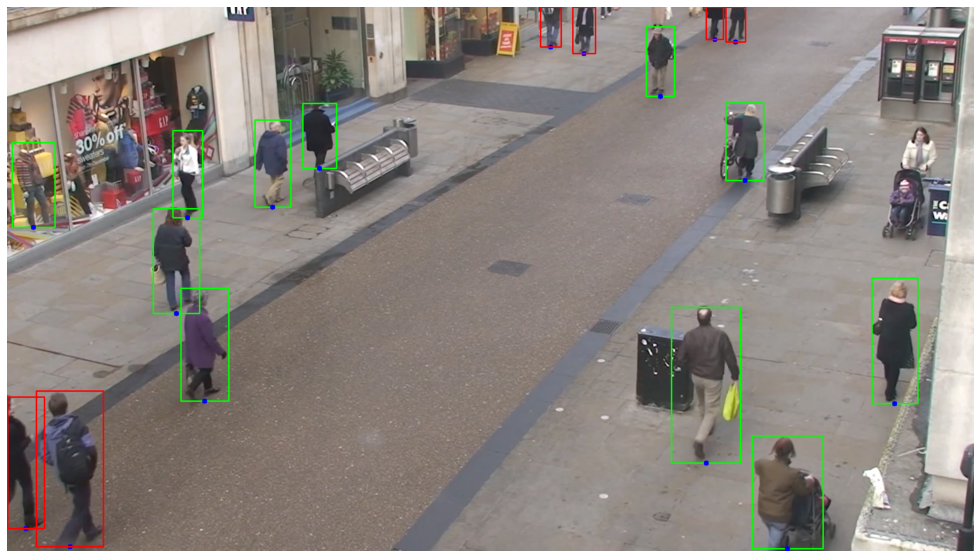

In [ ]:
image = change_2_red(image, persons_locations, p1, p2)

plt.figure(figsize=(20,10))
plt.imshow(image)
plt.axis("off")
plt.show()

## Processando um vídeo

In [ ]:
input_video_filename = "pedestrians.mp4"
output_video_filename = "pedestrians_output.mp4"
frame_size = (960,720)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 15.0
out = cv2.VideoWriter(output_video_filename,fourcc, fps, frame_size)

cap = cv2.VideoCapture(input_video_filename)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

threshold = 100

In [ ]:
pbar = tqdm_notebook(total=total_frames, desc="Processing video:")

while (cap.isOpened()):
    ret, frame = cap.read()
    pbar.update(1)

    if ret:
      frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
      frame = cv2.resize(frame, frame_size)

      outputs = predictor(frame)
      classes = outputs['instances'].pred_classes.cpu().numpy()
      objects_locations = outputs['instances'].pred_boxes.tensor.cpu().numpy()

      persons_index = np.where(classes==0)[0]
      persons_locations = objects_locations[persons_index]
      persons_total = len(persons_locations)
      
      midpoints = [get_mid_point(frame, persons_locations, i) for i in range(persons_total)]
      distances = compute_distances(midpoints, persons_total)      
      p1, p2, d = find_closest_points(distances, persons_total, threshold)
      frame = change_2_red(frame, persons_locations, p1, p2)
      
      frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)      
      out.write(frame)
    else:
      break

pbar.close()
out.release()
cap.release()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


# Analisando a detecção de cada pedestre

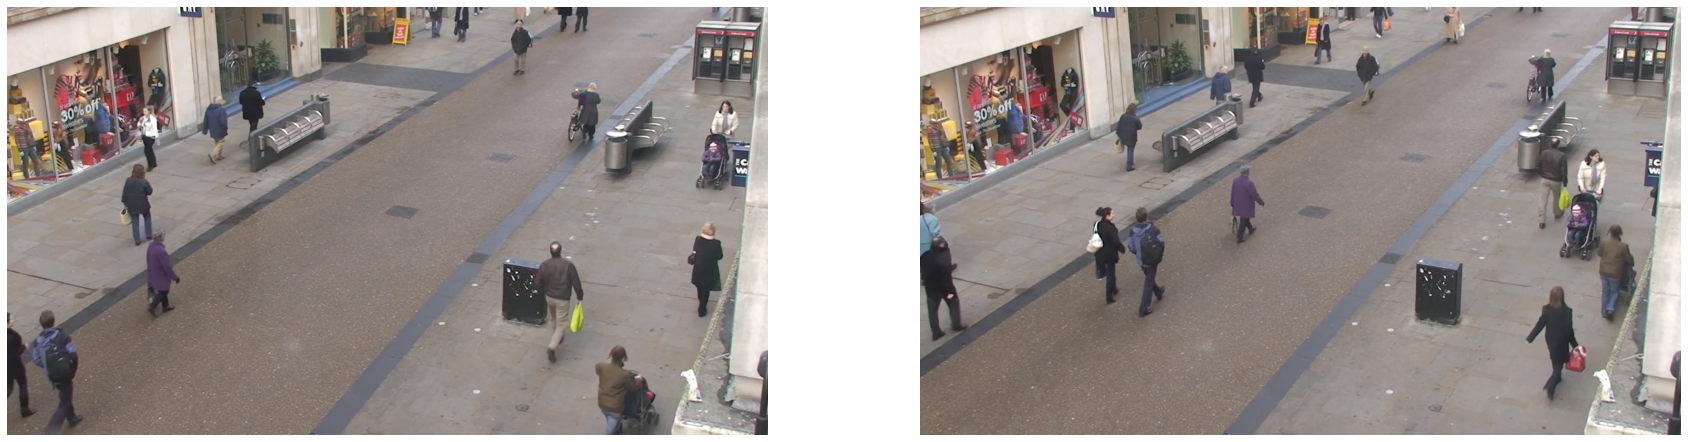

In [ ]:
frame_1 = cv2.imread("frame_1.png")
frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB)

frame_2 = cv2.imread("frame_2.png")
frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(30,15))

plt.subplot(121)
plt.imshow(frame_1)
plt.axis("off")

plt.subplot(122)
plt.imshow(frame_2)
plt.axis("off")

plt.show()

In [ ]:
# Processing Frame 1
outputs_1 = predictor(frame_1)
classes_1 = outputs_1['instances'].pred_classes.cpu().numpy()
objects_locations_1 = outputs_1['instances'].pred_boxes.tensor.cpu().numpy()

persons_index_1 = np.where(classes_1==0)[0]
persons_locations_1 = objects_locations_1[persons_index_1]
persons_total_1 = len(persons_locations_1)

midpoints_1 = [get_mid_point(frame_1, persons_locations_1, i, text=True) for i in range(persons_total_1)]

# Processing Frame 2
outputs_2 = predictor(frame_2)
classes_2 = outputs_2['instances'].pred_classes.cpu().numpy()
objects_locations_2 = outputs_2['instances'].pred_boxes.tensor.cpu().numpy()

persons_index_2 = np.where(classes_2==0)[0]
persons_locations_2 = objects_locations_2[persons_index_2]
persons_total_2 = len(persons_locations_2)

midpoints_2 = [get_mid_point(frame_2, persons_locations_2, i, text=True) for i in range(persons_total_2)]

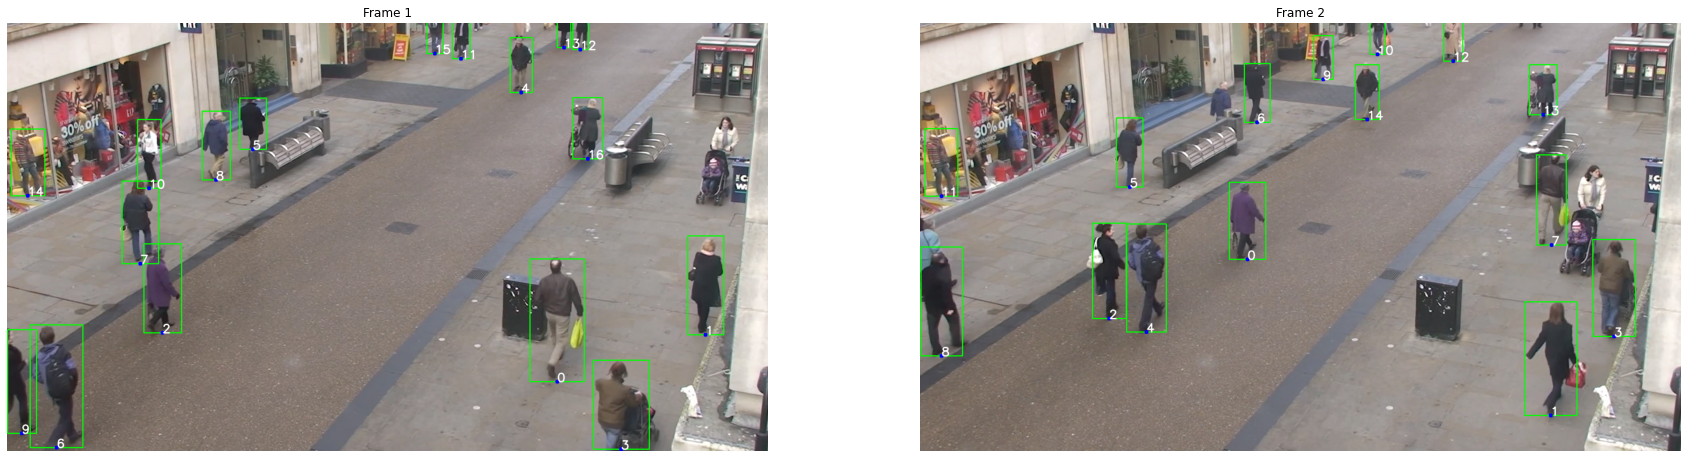

In [ ]:
plt.figure(figsize=(30,15))

plt.subplot(121)
plt.imshow(frame_1)
plt.axis("off")
plt.title("Frame 1")

plt.subplot(122)
plt.imshow(frame_2)
plt.axis("off")
plt.title("Frame 2")

plt.show()